<a href="https://colab.research.google.com/github/Jaesu26/Dacon-Basic/blob/main/%EC%8B%A0%EC%9A%A9%EC%B9%B4%EB%93%9C_%EC%82%AC%EA%B8%B0%ED%83%90%EC%83%89_%EC%98%A4%ED%86%A0%EC%9D%B8%EC%BD%94%EB%8D%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 신용카드 사기 거래 탐지 AI 경진대회

## 패키지 import

In [1]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from glob import glob
from tqdm import tqdm

warnings.filterwarnings(action='ignore')

In [143]:
SEED = 22
N_FOLD = 1
SAVE_PATH = './weight'
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 512

In [6]:
os.getcwd()

'C:\\Users\\Jaesu\\github_desktop\\Dacon-credit-card-fraud-detection'

In [7]:
train = pd.read_csv('./Data/train.csv')
valid = pd.read_csv('./Data/val.csv')
test = pd.read_csv('./Data/test.csv')
submission = pd.read_csv('./Data/sample_submission.csv')

In [8]:
train.drop('ID', axis=1, inplace=True)
valid.drop('ID', axis=1, inplace=True)
test.drop('ID', axis=1, inplace=True)

In [19]:
target = valid['Class']

In [20]:
valid.drop('Class', axis=1, inplace=True)

`-` label은 valid 데이터에만 있다

- 가중치 저장 폴더 생성

In [9]:
def create_folder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError as error:
        print(error)

In [10]:
create_folder(SAVE_PATH)

## 데이터 셋 및 오토인코더 모델 정의

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import f1_score, classification_report

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
print(f'현재 device는 {device}입니다')

현재 device는 cpu입니다


In [15]:
def seed_everything(seed: int = 22):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [16]:
seed_everything(SEED) ## 재현을 위한 seed 고정

In [94]:
features = ['V1', 'V3', 'V4', 'V5', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18'] ## 정상 분포와 사기 분포가 서로 겹치지 않는 변수 목록

- scaling

`-` 정확한 학습을 위해 변수들의 분포를 비슷하게 해주겠다

`-` 데이터에 이상점이 많으므로 z-표준화 대신 로버스트 표준화를 하겠다

In [33]:
scaler = RobustScaler()

In [34]:
scaler.fit(train)

RobustScaler()

In [35]:
train_scaled = scaler.transform(train)
train_scaled = pd.DataFrame(data=train_scaled, columns=train.columns)

valid_scaled = scaler.transform(valid)
valid_scaled = pd.DataFrame(data=valid_scaled, columns=valid.columns)

test_scaled = scaler.transform(test)
test_scaled = pd.DataFrame(data=test_scaled, columns=test.columns)

- 데이터 셋

In [18]:
class CustomDataset(Dataset):
  
    def __init__(self, X, y=None, is_valid=False, transforms=None):
        self.data = torch.tensor(X.to_numpy().astype(np.float32))
        self.labels = y
        self.transforms = transforms
        self.is_valid = is_valid
    
    def __getitem__(self, idx):
        data = self.data[idx]    
        if self.transforms is not None:
            data = self.transforms(data)

        if self.is_valid:
            labels = self.labels[idx]
            labels = torch.tensor(np.array(labels), dtype=torch.int64)
            return data, labels
        
        return data ## train과 test는 라벨이 없다
    
    def __len__(self):
        return self.data.shape[0] ## 데이터 개수 반환

- auto encoder

`-` VAE 모델: https://github.com/Jackson-Kang/Pytorch-VAE-tutorial/blob/master/01_Variational_AutoEncoder.ipynb

`-` 성능은 일반 오토인코더와 비슷함

`-` 모델에 $X$를 input하면 인코더가 $X$의 특징을 추출하고 디코더가 특징을 보고 $X$를 reconstruction하여 output으로 $\hat{X}$을 반환함 

In [109]:
class AutoEncoder(nn.Module):

    def __init__(self, input_dim, hidden_dim1):
        super().__init__()
        self.encoder = nn.Sequential(
          nn.Linear(input_dim, hidden_dim1),
          nn.GELU()
        )

        self.decoder = nn.Sequential(
          nn.Linear(hidden_dim1, input_dim),
          nn.GELU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

- layer 가중치 초기화 

In [22]:
## Linear layer 가중치 초기화
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        y = m.in_features
        m.weight.data.normal_(0.0, np.sqrt(2 / y))
        m.bias.data.fill_(0)

- 조기 중단

In [23]:
class EarlyStopping:
    ## 코드 참고: https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
    
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='./weight', n_fold=1):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 에폭
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint 저장 경로
                            Default: 'checkpoint.pt'
            n_fold (int): 현재 학습을 진행하는 fold의 순서
                            Default: 1
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.n_fold = n_fold

    def __call__(self, model, val_loss):

        score = -val_loss ## val_loss는 작을수록 좋다 ## score는 0에 가까울수록 좋다

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)  
        elif score < self.best_score + self.delta: ## loss가 개선되지 않았을 때
            self.counter += 1 ## 카운팅 +1
            # print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience: ## 만약 loss가 개선되지 않은 스탭이 patience보다 크거나 같아진다면 조기중단
                self.early_stop = True
        else: ## loss가 개선됨
            self.best_score = score ## score 갱신
            self.save_checkpoint(val_loss, model) ## loss와 model 저장
            self.counter = 0 ## loss가 개선되었으므로 0으로 초기화

    def save_checkpoint(self, val_loss, model):
        """validation loss가 감소하면 모델을 저장"""
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.5f} -> {val_loss:.5f})  Saving model ...')
        torch.save(model.state_dict(), self.path + f'/best_{self.n_fold}.pt') ## 모델의 계층별 가중치를 지정한 경로에 저장
        self.val_loss_min = val_loss ## 모델이 더 좋게 갱신되었으므로 이때의 valid loss를 기준치로 변경

- 스케줄러

In [24]:
import math
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWarmUpRestarts(_LRScheduler):
    ## 코드: https://github.com/gaussian37/pytorch_deep_learning_models/blob/master/cosine_annealing_with_warmup/cosine_annealing_with_warmup.py
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
            
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

## 모델 학습

- 손실 함수

In [25]:
loss_fn = nn.MSELoss()

- 훈련

In [26]:
def training(model: nn.Module, dataloader, optimizer, loss_fn, scheduler=None):
    """dataloader의 데이터를 사용하여 학습된 모델과 epoch 하나당 batch들의 평균 훈련 오차를 반환"""
    model.train() ## 훈련모드
    train_avg_loss = 0 ## 에폭별 배치단위 평균 훈련 오차
    train_total_batch = len(dataloader) ## 배치 크기

    for X in dataloader: ## 미니 배치 단위로 꺼내온다, X는 미니 배치, y는 레이블
        X = X.to(device)
        optimizer.zero_grad() ## 그래디언트 초기화
        X_hat = model(X)
        loss = loss_fn(X, X_hat).to(device) ## 오차를 계산 ## train loss
        loss.backward()  ## 미분
        optimizer.step() ## 업데이트
        train_avg_loss += (loss.item() / train_total_batch) ## 각 배치마다 훈련 오차 누적

    ## epoch마다 학습률 조절
    if scheduler is not None:
        scheduler.step()

    return model, train_avg_loss

- 평가

In [29]:
def evaluate(model: nn.Module, dataloader, loss_fn):
    """dataloader의 데이터를 사용하여 모델에 대한 epoch 하나당 batch들의 평균 평가 오차를 반환"""
    valid_avg_loss = 0

    model.eval() ## 평가모드
    with torch.no_grad(): ## 평가할 땐 역전파를 쓸 필요가 없으니까
        for X, y in dataloader: 
            X, y = X.to(device), y.to(device)
            X_hat = model(X)
            loss = loss_fn(X, X_hat).to(device) ## valid loss  
            valid_avg_loss += loss.item() / len(dataloader) ## 각 배치마다 평가 오차 누적    

    return valid_avg_loss

In [28]:
def show_loss_plot(train_loss: list, valid_loss: list, ax) -> None:
    epochs = len(train_loss)
    ax.set_title('Train Loss and Valid Loss')
    ax.plot(range(1, epochs+1), train_loss, label='Train')
    ax.plot(range(1, epochs+1), valid_loss, label='Valid')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()

In [187]:
seed_everything(SEED) ## 정확한 loss 재현을 위함
net_avg_acc = [] ## fold별 valid셋의 평균 정확도
net_avg_loss = [] ## fold별 valid셋의 평균 손실
net_epoch_train_loss = [[] for _ in range(N_FOLD)] ## fold별 train셋의 한 epoch당 valid셋의 배치 평균 손실
net_epoch_valid_loss = [[] for _ in range(N_FOLD)] ## fold별 valid셋의 한 epoch당 valid셋의 배치 평균 손실

# gc.collect()
# torch.cuda.empty_cache()

## early stopping
early_stopping = EarlyStopping(patience=10,
                                verbose=False,
                                path=SAVE_PATH,
                                n_fold=1) ## patience 횟수 에폭후에도 valid loss가 작아지지 않으면 조기 중단

## 딥러닝 모델
hd1 = 7
net = AutoEncoder(input_dim = len(features), hidden_dim1=hd1)
net.apply(init_weights) ## Linear layer 가중치 초기화

## Dataset, Dataloader
train_dataset = CustomDataset(X=train[features], y=None, is_valid=False, transforms=None)
valid_dataset = CustomDataset(X=valid[features], y=target, is_valid=True, transforms=None)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

## optimizer
optimizer = torch.optim.AdamW(net.parameters(), lr=LEARNING_RATE, weight_decay=1e-4) ## 옵티마이저에 최적화할 파라미터와 학습률 전달

## scheduler  
# scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=30, T_mult=1, eta_max=1e-3,  T_up=5, gamma=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

## fold별로 모델 학습
for epoch in tqdm(range(EPOCHS)): ## (배치사이즈 * 에폭)만큼 훈련시킴
    net, train_avg_loss = training(net, train_dataloader, optimizer, loss_fn, scheduler)  ## 모델 학습
    valid_avg_loss = evaluate(net, valid_dataloader, loss_fn)  ## 모델 평가
    net_epoch_train_loss[0].append(train_avg_loss) ## i번째 fold의 에폭 하나당 평균 배치 훈련 오차
    net_epoch_valid_loss[0].append(valid_avg_loss) ## i번째 fold의 에폭 하나당 평균 배치 평가 오차

    if epoch % 10 == 0 or epoch == EPOCHS - 1: 
        ## 10의 배수값을 가지는 에폭마다 평균 배치 훈련 오차와 평가 오차 출력
        print('[Epoch: {:>3}] train loss = {:>.5}  valid loss = {:>.5}'.format(epoch + 1, train_avg_loss, valid_avg_loss)) 
        
    ## epoch마다 early stopping 실행
    early_stopping(net, valid_avg_loss) ## __call__ function
    if early_stopping.early_stop: ## early_stop이 true이면
        if epoch % 10 != 0 and epoch != EPOCHS - 1:
            print('[Epoch: {:>3}] train loss = {:>.5}  valid loss = {:>.5}'.format(epoch + 1, train_avg_loss, valid_avg_loss)) 
        print('Early stopping!')
        break 

net_avg_loss.append(early_stopping.val_loss_min) ## fold별 loss가 가장 작은 모델의 손실

## fold별 평가 루프 종료시 가장 작은 loss를 출력
print(f' Best Valid Loss: {early_stopping.val_loss_min:.4f}\n\n')

  2%|█▋                                                                                 | 1/50 [00:01<01:23,  1.71s/it]

[Epoch:   1] train loss = 1.9579  valid loss = 1.5376


 22%|██████████████████                                                                | 11/50 [00:16<00:58,  1.51s/it]

[Epoch:  11] train loss = 0.93939  valid loss = 0.92836


 42%|██████████████████████████████████▍                                               | 21/50 [00:33<00:42,  1.48s/it]

[Epoch:  21] train loss = 0.8902  valid loss = 0.88828


 62%|██████████████████████████████████████████████████▊                               | 31/50 [00:47<00:28,  1.51s/it]

[Epoch:  31] train loss = 0.88689  valid loss = 0.88059


 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [01:02<00:14,  1.61s/it]

[Epoch:  41] train loss = 0.88399  valid loss = 0.87891


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:17<00:00,  1.54s/it]

[Epoch:  50] train loss = 0.88449  valid loss = 0.87933
 Best Valid Loss: 0.8785




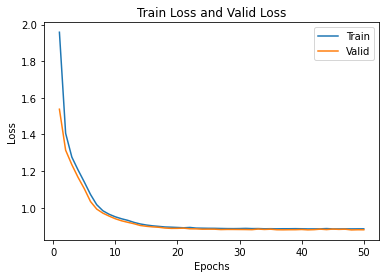

In [188]:
## fold별 epoch당 train loss와 valid loss의 변화
fig, ax = plt.subplots(1, 1)
show_loss_plot(net_epoch_train_loss[0], net_epoch_valid_loss[0], ax=ax)

## 모델 검증

In [189]:
net = AutoEncoder(input_dim=len(features), hidden_dim1=hd1).to(device)

In [190]:
weight_path = glob(SAVE_PATH + '/*.pt')

In [191]:
net.load_state_dict(torch.load(*weight_path, map_location=device))
net.eval()

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=13, out_features=7, bias=True)
    (1): GELU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=7, out_features=13, bias=True)
    (1): GELU()
  )
)

In [192]:
valid_data = torch.tensor(np.array(valid[features]).astype(np.float32))

In [193]:
with torch.no_grad():
    X_hat = net(valid_data)
    losses = torch.mean((valid_data - X_hat) ** 2, axis=1).cpu().data.numpy()

<AxesSubplot:>

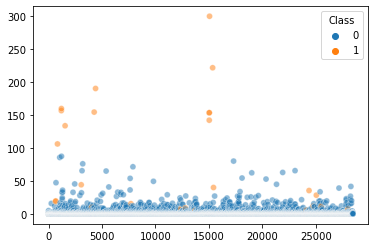

In [194]:
sns.scatterplot(x=list(range(valid.shape[0])), y=losses, hue=target, alpha=0.5)

In [195]:
threshold = 100

In [196]:
preds = losses.copy()

In [197]:
preds[preds < threshold] = 0 ## 정상
preds[(preds >= threshold)] = 1 ## 비정상

In [198]:
print(classification_report(target, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       1.00      0.37      0.54        30

    accuracy                           1.00     28462
   macro avg       1.00      0.68      0.77     28462
weighted avg       1.00      1.00      1.00     28462



In [199]:
len(preds[preds==1])

11

In [200]:
f1_score(target, preds, average='macro')

0.7681256734512389

## test 예측

In [201]:
def predict(model: nn.Module, test, weight_save_path, threshold) -> np.array:
    """저장된 모델의 가중치를 불러와서 dataloader의 각 데이터를 예측하여 반환"""
    model = model.to(device) ## device는 전역변수
    model.eval()
    weight_path_list = glob(weight_save_path + '/*.pt')

    for weight in weight_path_list :
        model.load_state_dict(torch.load(weight, map_location=device))
        model.eval()
        test_data = torch.tensor(np.array(test[features]).astype(np.float32))
        
        with torch.no_grad():
            X_hat = net(test_data)
            losses = torch.mean((test_data - X_hat) ** 2, axis=1).cpu().data.numpy() 
                            
    preds = losses.copy()
    preds[preds < threshold] = 0 ## 정상
    preds[(preds >= threshold)] = 1 ## 비정상
    return preds

In [202]:
net = AutoEncoder(input_dim=len(features), hidden_dim1=hd1).to(device)

In [203]:
test_preds = predict(net, test, SAVE_PATH, threshold)